In [32]:
import os
import sys
sys.path.append("../")

import tensorflow as tf
from glob import glob
from typing import List
from matplotlib import pyplot as plt
import numpy as np
from numpy import ndarray
from typing import Dict, List, Union
from rosbag2numpy import config as params
from rosbag2numpy.data_processing.data_loader_fv import dataset_loader
import time
from tqdm import trange
from rosbag2numpy import SEED
from typing import List
print(tf.__version__)
tf.random.set_seed(SEED)
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

2.3.0


## Load data set

In [4]:
ds_loader = dataset_loader(
    tfrec_dir=params.get("data_dir"),
    #'/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_bgm_fv_diff_unequal',#params.get("data_dir"),
    batch_size=32,
    shuffle_buffer=3200,
    normalize_coords=True,
    normalize_factor=1536.0
)
ds_train, ds_valid, ds_test, ds_test_all = ds_loader.build_scenario_dataset(no_train_scene=8,no_valid_scene=1,no_test_scene=1)

Scenarios:['/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_cm_fv_diff_unequal/scenario1', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_cm_fv_diff_unequal/scenario2', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_cm_fv_diff_unequal/scenario3', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_cm_fv_diff_unequal/scenario4', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_cm_fv_diff_unequal/scenario5', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_cm_fv_diff_unequal/scenario_ph_11', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_cm_fv_diff_unequal/scenario_ph_12', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_cm_fv_diff_unequal/scenario_ph_13', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_cm_fv_diff_unequal/scenario_ph_14', '/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_cm_fv_diff_unequal/scenario_ph_15']
Test scenario:['/bigpool/projects/yao_SCANGAN360/New_Folder/tf_records_w_c

## Numpy data for test set and visual inspection

In [5]:
def _get_test_ds_size(ds_test) -> int:
    """get the size of test dataset

    Args:
        ds_test (tf.data.Dataset): [description]

    Returns:
        [int]: [Number of Samples inside dataset]
    """
    num_of_samples = 0
    # Looping through all batches in test dataset
    for input_batch, output_batch in ds_test:
        # Looping through all samples for a single (current) batch
        #print(input_batch[0].numpy().shape)
        for _ in range(0, len(input_batch[0].numpy())):
            num_of_samples += 1
    return num_of_samples

def get_np_test_ds(ds_test) -> Dict[str, Union[ndarray, List]]:
    """Test dataset (in tf.data.Dataset build) to numpy arrays

    Args:
        ds_test ([type]): tf.data.Dataset

    Returns:
        Dict[str,Union[ndarray,List]]: dictionary of feature_vector,costmap,init_path,opt_path,car_odo,file_details,unequal_indices, diff_path
    """
    samples = _get_test_ds_size(ds_test)
    np_tst_feature_vector = np.zeros(shape=(samples,25,1040))
    np_tst_costmap = np.zeros(shape=(samples, 1536, 1536)).astype(np.float16)
    
    #np_tst_left_bnd = np.zeros(shape=(samples, 25, 2))
    #np_tst_right_bnd = np.zeros(shape=(samples, 25, 2))
    np_tst_car_odo = np.zeros(shape=(samples, 2))
    np_tst_init_path = np.zeros(shape=(samples, 25, 2))
    np_tst_opt_path = np.zeros(shape=(samples, 25, 2))
    list_tst_file_details = []

    #list_unequal_indices = []

    #output
    np_tst_diff_path = np.zeros(shape=(samples, 25, 2))

    j = 0
    for input_batch, output_batch in ds_test:

        for i in range(len(input_batch[0].numpy())):
            np_tst_feature_vector[j] = input_batch[0][i].numpy()
            np_tst_costmap[j] = input_batch[1][i].numpy().astype(np.float16)
            #np_tst_grid_org_res[j] = input_batch[1][i].numpy()
            #np_tst_left_bnd[j] = input_batch[2][i].numpy()
            #np_tst_right_bnd[j] = input_batch[3][i].numpy()
            np_tst_init_path[j] = input_batch[2][i].numpy()
            np_tst_opt_path[j] = input_batch[3][i].numpy()
            np_tst_car_odo[j] = input_batch[4][i].numpy()
            list_tst_file_details.append(input_batch[5][i])
            #list_unequal_indices.append(input_batch[6][i])

            #np_tst_opt_path[j] = output_batch[i].numpy()
            np_tst_diff_path[j] = output_batch[i].numpy()
            j = j + 1

    np_ds_test = {
        "feature_vector": np_tst_feature_vector,
        "cost_map": np_tst_costmap,
        #"grid_org_res": np_tst_grid_org_res,
        #"left_bnd": np_tst_left_bnd,
        #"right_bnd": np_tst_right_bnd,
        "init_path": np_tst_init_path,
        "opt_path": np_tst_opt_path,
        "car_odo": np_tst_car_odo,
        "file_details": list_tst_file_details,
        #"unequal_indices": list_unequal_indices,
        "diff_path": np_tst_diff_path,

    }

    # np_tst_gridmap,np_tst_grid_org_res,np_tst_left_bnd,np_tst_right_bnd,np_tst_car_odo,np_tst_init_path,list_tst_file_details,np_tst_opt_path
    return np_ds_test

np_test_ds_all = get_np_test_ds(ds_test=ds_test_all)

cost_map = np_test_ds_all["cost_map"]
feature_v = np_test_ds_all["feature_vector"]
init_path = np_test_ds_all["init_path"]
opt_path = np_test_ds_all["opt_path"]
car_odo = np_test_ds_all["car_odo"]
file_details = np_test_ds_all["file_details"]
diff_path = np_test_ds_all["diff_path"]

## Load pretrained model

In [73]:
wandbmodel_path = '/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/wandb/run-20210925_083501-7b6nj1fr/files/model-best.h5'
#'/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/wandb/run-20210925_083501-7b6nj1fr/files/model-best.h5' (breezy-sweep-15)
#'/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/wandb/run-20210925_080546-xoxoxow6/files/model-best.h5' (prime-sweep-5)
#'/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/wandb/run-20210924_031631-lhsjbn8r/files/model-best.h5' (laced-sweep-28)
#'/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/wandb/run-20210922_162541-2bwn3ku4/files/model-best.h5'  (iconic-silence- , hybrid (2,2))
#'/netpool/work/gpu-3/users/malyalasa/New_folder/wandb/run-20210922_010110-1sb0es02/files/model-best.h5' (quiet-meadow-14, LSTM (25,50))
#'/netpool/work/gpu-3/users/malyalasa/New_folder/wandb/run-20210921_225739-3tq5o6wv/files/model-best.h5' (noble-ebergy-9,bidiLSTM)
#'/netpool/work/gpu-3/users/malyalasa/New_folder/wandb/run-20210921_223929-2789gz0e/files/model-best.h5' (dark-energy-TDD-64)
#'/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/wandb/run-20210922_154305-30js7pw0/files/model-best.h5' (divine-snow-LSTM(2,50))

all_model_paths = ['/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/wandb/run-20210925_083501-7b6nj1fr/files/model-best.h5' , 
'/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/wandb/run-20210925_080546-xoxoxow6/files/model-best.h5' ,
'/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/wandb/run-20210924_031631-lhsjbn8r/files/model-best.h5' ,
'/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/wandb/run-20210922_162541-2bwn3ku4/files/model-best.h5'  ,
'/netpool/work/gpu-3/users/malyalasa/New_folder/wandb/run-20210922_010110-1sb0es02/files/model-best.h5' ,
'/netpool/work/gpu-3/users/malyalasa/New_folder/wandb/run-20210921_225739-3tq5o6wv/files/model-best.h5' ,
'/netpool/work/gpu-3/users/malyalasa/New_folder/wandb/run-20210921_223929-2789gz0e/files/model-best.h5' ,
'/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/wandb/run-20210922_154305-30js7pw0/files/model-best.h5' ]

load_wandb  = tf.keras.models.load_model(wandbmodel_path)
predictions = load_wandb.predict(feature_v)
predicted_paths = init_path - predictions
predicted_paths.shape
np.shape(np.expand_dims(feature_v[0],axis=0))

len(all_model_paths)


8

## profile predict function 

In [89]:
def profile_predict():
    load_wandb.predict(feature_v)

%load_ext line_profiler

%lprun -f profile_predict profile_predict()


The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


Timer unit: 1e-06 s

Total time: 0.163236 s
File: <ipython-input-89-bb3b8e5812e9>
Function: profile_predict at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def profile_predict():
     2         1     163236.0 163236.0    100.0      load_wandb.predict(feature_v)

## Saving keras model

In [5]:
# Saving keras models
#step 1
# serialize model to json(no weights, only structure)
"""
with open('best_model.json','w') as f:
    f.write(pp_model.to_json())
"""
#step 2
"""
pp_model.save_weights('best_keras_weights.h5')
"""

#step 3
# Load serialized model from json(contains no weights only structue)

"""json_file = open('best_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
pp_model = tf.keras.models.model_from_json(loaded_model_json,custom_objects={'CustomMaskLayer':endpoint_in_model.CustomMaskLayer})
"""
#step4
# load weights into model created from json

"""pp_model.load_weights('/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/keras_weights.h5')
"""


"""
opt = tf.keras.optimizers.Adam(learning_rate=0.02)
pp_model.compile(
        optimizer=opt, 
        loss=[euclidean_distance_loss,endpoint_loss],
        loss_weights=params.get("loss_weights"), metrics=params.get("metric")
    )#pp_model.summary()
test_loss,test_accuracy = pp_model.evaluate(ds_test)
"""

'\nopt = tf.keras.optimizers.Adam(learning_rate=0.02)\npp_model.compile(\n        optimizer=opt, \n        loss=[euclidean_distance_loss,endpoint_loss],\n        loss_weights=params.get("loss_weights"), metrics=params.get("metric")\n    )#pp_model.summary()\ntest_loss,test_accuracy = pp_model.evaluate(ds_test)\n'

## Plotting individual sample

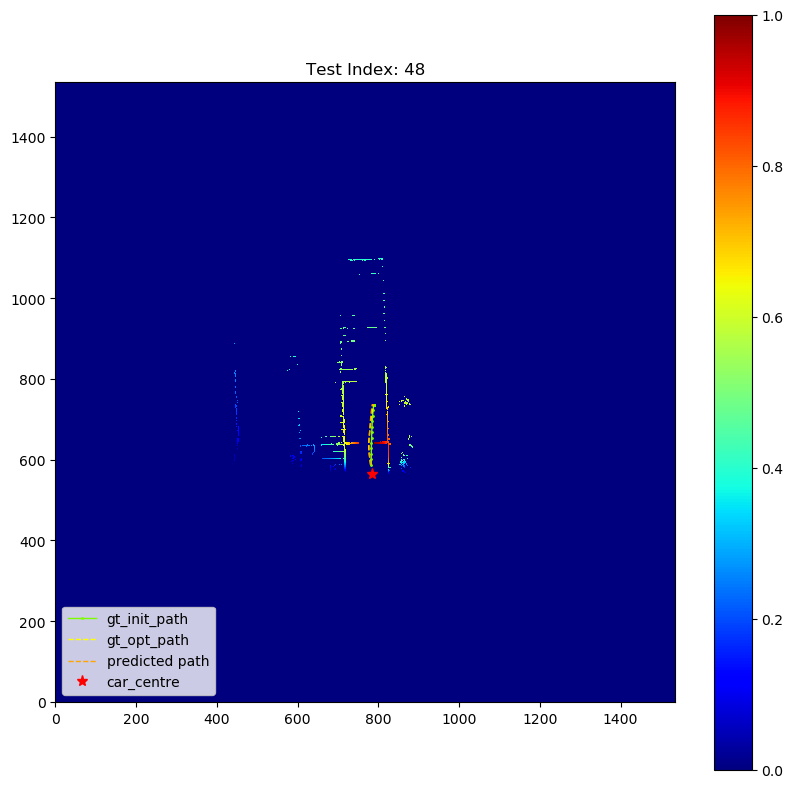

In [54]:
normalized_factor=1536
idx=48
plt.figure(figsize=(10,10),dpi=100)
plt.imshow(cost_map[idx].astype(float),origin='lower',cmap='jet')
plt.colorbar()
plt.plot(
    init_path[idx][:, 0]*normalized_factor,
    init_path[idx][:, 1]*normalized_factor,
    "o-",
    color="lawngreen",
    markersize=1,
    linewidth=1,
)
plt.plot(
    opt_path[idx][:, 0]*normalized_factor,
    opt_path[idx][:, 1]*normalized_factor,
    "--",
    color="yellow",
    markersize=1,
    linewidth=1,
)

plt.plot(
    predicted_paths[idx][:, 0]*normalized_factor,
    predicted_paths[idx][:, 1]*normalized_factor,
    "--",
    color="orange",
    markersize=1,
    linewidth=1,
)
plt.plot(car_odo[idx][0] *normalized_factor,car_odo[idx][1] *normalized_factor,
    "r*",
    color="red",
    markersize=8,
)
plt.legend(['gt_init_path', 'gt_opt_path', 'predicted path','car_centre'], loc='lower left')
plt.title(f"Test Index: {idx}")
plt.show()
file_name = file_details[idx].numpy().decode('utf-8').replace("cm_fv_paths_odo_unequal.npz","")


## Metrics and evaluation
 * DTW (Dynamic time warp)
 * ADE (Average Displacement error)


In [88]:
from pydtw import dtw2d
from tqdm import tqdm
from pyts.metrics import dtw_multiscale
from datetime import datetime

def calc_dtw(optimized_path_gt:ndarray, predicted_paths_m:ndarray)->List:
    all_cost = []
    for index in trange(optimized_path_gt.shape[0]):
        cost_matrix, cost, _,_ = dtw2d(optimized_path_gt[index],predicted_paths_m[index])
        all_cost.append(cost)
    return all_cost

def ADE(optimized_path_gt:ndarray, predicted_paths_m:ndarray):
    # batchsize,25,2
    dist = np.mean(np.sqrt(np.sum((optimized_path_gt - predicted_paths_m)**2,axis=2)),axis=1)
    #np.linalg.norm(optimized_path_gt - predicted_paths_m)
    print(sum(dist)/len(dist))
    return sum(dist)/len(dist)

def eval_models(model_paths:List[str],opt_paths,save_results:bool=False):

    for i,m_path in tqdm(enumerate(model_paths)):

        load_wandb  = tf.keras.models.load_model(m_path)
        predictions = load_wandb.predict(feature_v)
        predicted_paths = init_path - predictions

        scaled_opt_paths = opt_paths*1536
        scaled_predicted_paths = predicted_paths*1536

        dtw = calc_dtw(optimized_path_gt=scaled_opt_paths,predicted_paths_m=scaled_predicted_paths)
        avg_de = ADE(optimized_path_gt=scaled_opt_paths,predicted_paths_m=scaled_predicted_paths)

        print(f"\n Model: {m_path.split('/')[-3]}, DTW: {sum(dtw):.3f}, avg_DTW:{np.mean(dtw):.3f}, ADE: {avg_de}")

        if save_results:
            file_path = '/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/test_results/metrics_results'
            file_path = os.path.join(file_path,'all_results.txt')
            with open(file_path, 'a') as f:
                if i==0:
                    f.write(f"INFO: {datetime.now()}\n")
                f.write(f"Model: {m_path.split('/')[-3]}, DTW: {sum(dtw):.3f}, avg_DTW:{np.mean(dtw):.3f}, ADE: {avg_de:.3f} \n")
                f.close()

eval_models(model_paths=all_model_paths,opt_paths=opt_path)


100%|██████████| 144/144 [00:00<00:00, 21613.16it/s]
1it [00:02,  2.22s/it]

0.9156808206555083

 Model: run-20210925_083501-7b6nj1fr, DTW: 39412.427, avg_DTW:273.697, ADE: 0.9156808206555083


100%|██████████| 144/144 [00:00<00:00, 18131.54it/s]
2it [00:03,  1.72s/it]

0.8791481510725991

 Model: run-20210925_080546-xoxoxow6, DTW: 38132.924, avg_DTW:264.812, ADE: 0.8791481510725991


100%|██████████| 144/144 [00:00<00:00, 19996.02it/s]
3it [00:04,  1.49s/it]

0.8848795484882046

 Model: run-20210924_031631-lhsjbn8r, DTW: 38191.162, avg_DTW:265.216, ADE: 0.8848795484882046


100%|██████████| 144/144 [00:00<00:00, 16614.76it/s]
4it [00:05,  1.19s/it]

1.1648235606022477

 Model: run-20210922_162541-2bwn3ku4, DTW: 49118.381, avg_DTW:341.100, ADE: 1.1648235606022477


100%|██████████| 144/144 [00:00<00:00, 16047.50it/s]
5it [00:07,  1.30s/it]

0.8743614203129767

 Model: run-20210922_010110-1sb0es02, DTW: 38236.132, avg_DTW:265.529, ADE: 0.8743614203129767


100%|██████████| 144/144 [00:00<00:00, 16647.73it/s]
7it [00:10,  1.33s/it]

1.1472980719916133

 Model: run-20210921_225739-3tq5o6wv, DTW: 51149.363, avg_DTW:355.204, ADE: 1.1472980719916133
1.0942018039414247

 Model: run-20210921_223929-2789gz0e, DTW: 48197.471, avg_DTW:334.705, ADE: 1.0942018039414247


100%|██████████| 144/144 [00:00<00:00, 20202.70it/s]
8it [00:12,  1.50s/it]

0.8610434090928311

 Model: run-20210922_154305-30js7pw0, DTW: 36286.785, avg_DTW:251.992, ADE: 0.8610434090928311


In [ ]:
print(f'optimized_paths: {scaled_opt_paths[0]}\n')


In [33]:
SAVE_ALL = False
if SAVE_ALL:
    model_name = wandbmodel_path.split("/")[-3]#'bgm_LSTM_2_50'#wandbmodel_path.split("/")[-3]
    #'TDD_64_first'#wandbmodel_path.split("/")[-3]#'TDD_4_2'
    save_dir_root = '/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/test_results/feature_vec_res'

    #%matplotlib agg
    #idx= 23#35#23#54#50#25#122#82#42#48
    normalized_factor=1536

    for idx in trange(predicted_paths.shape[0]):

        plt.figure(figsize=(10,10),dpi=200)
        plt.imshow(cost_map[idx].astype(float),origin='lower',cmap='jet')
        plt.colorbar()
        plt.plot(
            init_path[idx][:, 0]*normalized_factor,
            init_path[idx][:, 1]*normalized_factor,
            "o-",
            color="lawngreen",
            markersize=1,
            linewidth=1,
        )
        plt.plot(
            opt_path[idx][:, 0]*normalized_factor,
            opt_path[idx][:, 1]*normalized_factor,
            "--",
            color="yellow",
            markersize=1,
            linewidth=1,
        )
        plt.plot(
            predicted_paths[idx][:, 0]*normalized_factor,
            predicted_paths[idx][:, 1]*normalized_factor,
            "--",
            color="orange",
            markersize=1,
            linewidth=1,
        )
        plt.plot(car_odo[idx][0] *normalized_factor,car_odo[idx][1] *normalized_factor,
            "r*",
            color="red",
            markersize=8,
        )
        plt.legend(['gt_init_path', 'gt_opt_path', 'predicted path','car_centre'], loc='lower left')

        file_name = file_details[idx].numpy().decode('utf-8').replace("cm_fv_paths_odo_unequal.npz","")
        plt.title(f"{file_name}\nTest Index: {idx}")

        split_details = os.path.split(file_name)[0]
        scene_name = os.path.split(split_details)[0]
        
        # directory t save 
        save_dir = os.path.join(save_dir_root,model_name,scene_name)

        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        plt.savefig(f"{save_dir}/Test_index_{idx}.png",dpi=200)
        plt.close()

    

100%|██████████| 144/144 [01:51<00:00,  1.29it/s]


## Save all plots from test set

## Iteration robustness check

In [ ]:
def get_feature_vector_old(gridmap:ndarray,init_path:ndarray,offset)->ndarray:
    feature_vector = np.zeros(shape=(init_path.shape[0],4*offset[0]*offset[1]))
    # np.array(init_path.shape[0],4*offset[0]*offset[1])
    for i in range(init_path.shape[0]):
        x_l,y_l = (init_path[i].astype(int)) - offset
        x_h,y_h = (init_path[i].astype(int)) + offset
        cell = 0
        #print("lower:",(x_l,y_l))
        #print("higher:",(x_h,y_h))

        for x in range(x_l,x_h):
            for y in range(y_l,y_h):
                #print(x,y)
                #if cell<feature_vector.shape[1]:
                    #gridmap[row][column]
                feature_vector[i][cell] = gridmap[y][x]
                cell+=1
    return feature_vector

# optimized version (matrix extraction)
def get_feature_vector(gridmap:ndarray,init_path:ndarray,offset)->ndarray:
    feature_vector = np.zeros(shape=(init_path.shape[0],4*offset[0]*offset[1]))
    for i in range(init_path.shape[0]):
        x_l,y_l = (init_path[i].astype(int)) - offset
        x_h,y_h = (init_path[i].astype(int)) + offset
        
        # boundary box snip from costmap
        feature_vector[i] = gridmap[y_l:y_h,x_l:x_h].flatten()
        
    return feature_vector


idx=80
sample_init = np_test_ds_all["init_path"][idx]
sample_opt = np_test_ds_all["opt_path"][idx]
sample_gm = np_test_ds_all["cost_map"][idx]
sample_odo = np_test_ds_all["car_odo"][idx]
sample_fv = np_test_ds_all["feature_vector"][idx]
sample_gt_diff = np_test_ds_all["diff_path"][idx]
sample_file_details = np_test_ds_all["file_details"][idx]

def iter_plot_sample(save,cost_map:ndarray,init_path:ndarray,opt_path:ndarray,predicted_path:ndarray,car_odo:ndarray,file_details,itn,idx):
    norm_fac = 1536
    plt.figure(figsize=(10,10),dpi=400)
    
    plt.imshow(cost_map.astype(float),origin='lower',cmap='jet')
    plt.colorbar()
    plt.plot(
        init_path[:, 0]*norm_fac,
        init_path[:, 1]*norm_fac,
        "o-",
        color="lawngreen",
        markersize=1,
        linewidth=1,
    )
    plt.plot(
        opt_path[:, 0]*norm_fac,
        opt_path[:, 1]*norm_fac,
        "--",
        color="yellow",
        markersize=1,
        linewidth=1,
    )
    plt.plot(
        predicted_path[:, 0]*norm_fac,
        predicted_path[:, 1]*norm_fac,
        "--",
        color="orange",
        markersize=1,
        linewidth=1,
    )
    plt.plot(car_odo[0] *norm_fac,car_odo[1] *norm_fac,
        "r*",
        color="red",
        markersize=8,
    )

    file_name = file_details.numpy().decode('utf-8').replace("cm_fv_paths_odo_unequal.npz","")
    plt.title(f"{file_name}\nTest_sample:{id}\nTest iteration: {itn}")
    plt.legend(['gt_init_path', 'gt_opt_path', 'predicted_path','car_centre'], loc='lower left')
    
    split_details = os.path.split(file_name)[0]
    scene_name = os.path.split(split_details)[0]
    save_dir_root='/netpool/work/gpu-3/users/malyalasa/New_folder/rosbag2numpy/test_results/iter_results'
    model_name = wandbmodel_path.split("/")[-3]
    # directory t save 
    save_dir = os.path.join(save_dir_root,model_name,scene_name)

    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    if save:
        plt.savefig(f"{save_dir}/Test_index_{idx}_iter_{itn}.png",dpi=300)
        plt.close()
    #plt.show()

for itn in trange(5):
    model_output = load_wandb.predict(np.expand_dims(sample_fv,axis=0))
    pred_path = (sample_init -model_output)[0]
    iter_plot_sample(save=False,cost_map=sample_gm,init_path=sample_init,opt_path=sample_opt, predicted_path=pred_path, car_odo=sample_odo, file_details = sample_file_details,itn=itn,idx=idx)

    sample_init = pred_path
    sample_fv = get_feature_vector(gridmap=sample_gm,init_path=sample_init*1536,offset=[13,20])


## Line profile of feature vector function

In [141]:
%load_ext line_profiler

#%lprun -f get_feature_vector_new get_feature_vector_new(gridmap=sample_gm,init_path=sample_init*1536,offset=[13,20])


The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


Timer unit: 1e-06 s

Total time: 0.001845 s
File: <ipython-input-21-c68dd37fe6a3>
Function: get_feature_vector_new at line 20

Line #      Hits         Time  Per Hit   % Time  Line Contents
    20                                           def get_feature_vector_new(gridmap:ndarray,init_path:ndarray,offset)->ndarray:
    21         1         49.0     49.0      2.7      feature_vector = np.zeros(shape=(init_path.shape[0],4*offset[0]*offset[1]))
    22        26         32.0      1.2      1.7      for i in range(init_path.shape[0]):
    23        25        248.0      9.9     13.4          x_l,y_l = (init_path[i].astype(int)) - offset
    24        25        247.0      9.9     13.4          x_h,y_h = (init_path[i].astype(int)) + offset
    25                                                   
    26                                                   # boundary box snip from costmap
    27        25       1268.0     50.7     68.7          feature_vector[i] = gridmap[y_l:y_h,x_l:x_h].flatten(